### IMPORTS

In [1]:
import sys, os
sys.path.append(os.path.join(sys.path[0],'Pythons'))

In [2]:
from Carga_Descarga import *
from CRM_Central import *

In [307]:
from scipy.optimize import curve_fit
import copy
import matplotlib.pyplot as plt
from numpy import arange

### QUERIES

In [448]:
q_m1 = '''WITH acq_table AS (
    SELECT o.user.id AS user,
           o.registered_date AS fecha,
           cn.country_name AS country,
           CASE WHEN tc.order_id IS NOT NULL THEN 'Con Voucher' ELSE 'Sin Voucher' END AS voucher,
    FROM `peya-bi-tools-pro.il_core.fact_orders` AS o
    LEFT JOIN `peya-bi-tools-pro.il_core.dim_country` AS cn ON o.country_id = cn.country_id
    LEFT JOIN `peya-bi-tools-pro.il_growth.fact_talon_coupons` AS tc ON o.order_id = tc.order_id
    WHERE o.registered_date BETWEEN DATE('2021-04-01') AND DATE('2021-06-30')
          AND o.is_acquisition = 1),
    cohorts_table AS (
    SELECT acq.user AS user,
           acq.country AS country,
           FORMAT_DATE('%Y-%m',acq.fecha) AS acq_month,
           acq.voucher AS voucher,
           MIN(o.registered_date) AS m1_fecha
    FROM acq_table AS acq
    LEFT JOIN `peya-bi-tools-pro.il_core.fact_orders` AS o ON acq.user = o.user.id
    WHERE o.registered_date BETWEEN DATE('2021-04-01') AND DATE('2021-07-31')
          AND o.registered_date BETWEEN DATE_TRUNC(DATE_ADD(acq.fecha,INTERVAL 1 MONTH),MONTH) AND LAST_DAY(DATE_ADD(acq.fecha,INTERVAL 1 MONTH))
          AND o.order_status = 'CONFIRMED'
    GROUP BY 1,2,3,4),
    acq_final_table AS (
    SELECT FORMAT_DATE('%Y-%m',acq.fecha) AS acq_month,
           acq.country AS country,
           acq.voucher AS voucher,
           COUNT(DISTINCT acq.user) AS users
    FROM acq_table AS acq 
    GROUP BY 1,2,3)
SELECT ct.acq_month AS Month,
       ct.country AS Country,
       ct.voucher AS Voucher,
       ct.m1_fecha AS M1_Fecha,
       IFNULL(aft.users,0) AS Acq,
       COUNT(DISTINCT ct.user) AS Reorders
FROM cohorts_table AS ct
LEFT JOIN acq_final_table AS aft ON ct.acq_month = aft.acq_month AND ct.country = aft.country AND ct.voucher = aft.voucher
GROUP BY 1,2,3,4,5
ORDER BY 2,1,4,3'''

q_reo = '''WITH users_table AS (
    SELECT o.user.id AS user,
           DATE_TRUNC(o.registered_date,MONTH) AS fecha,
           cn.country_name AS country,
           SUM(IFNULL(o.is_acquisition,0)) AS acq
    FROM `peya-bi-tools-pro.il_core.fact_orders` AS o
    LEFT JOIN `peya-bi-tools-pro.il_core.dim_country` AS cn ON o.country_id = cn.country_id
    WHERE o.registered_date BETWEEN DATE('2021-04-01') AND DATE('2021-06-30')
          AND o.order_status = 'CONFIRMED'
    GROUP BY 1,2,3),
    cohorts_table AS (
    SELECT ut.user AS user,
           ut.country AS country,
           FORMAT_DATE('%Y-%m',ut.fecha) AS user_month,
           MIN(o.registered_date) AS reorder_fecha
    FROM users_table AS ut
    LEFT JOIN `peya-bi-tools-pro.il_core.fact_orders` AS o ON ut.user = o.user.id
    WHERE o.registered_date BETWEEN DATE('2021-04-01') AND DATE('2021-07-31')
          AND o.registered_date BETWEEN DATE_TRUNC(DATE_ADD(ut.fecha,INTERVAL 1 MONTH),MONTH) AND LAST_DAY(DATE_ADD(ut.fecha,INTERVAL 1 MONTH))
          AND o.order_status = 'CONFIRMED'
          AND ut.acq = 0
    GROUP BY 1,2,3),
    users_final_table AS (
    SELECT FORMAT_DATE('%Y-%m',ut.fecha) AS user_month,
           ut.country AS country,
           COUNT(DISTINCT ut.user) AS users
    FROM users_table AS ut
    WHERE ut.acq = 0
    GROUP BY 1,2)
SELECT ct.user_month AS Month,
       ct.country AS Country,
       ct.reorder_fecha AS Reorder_Fecha,
       IFNULL(uft.users,0) AS Users,
       COUNT(DISTINCT ct.user) AS Reorders
FROM cohorts_table AS ct
LEFT JOIN users_final_table AS uft ON ct.user_month = uft.user_month AND ct.country = uft.country
GROUP BY 1,2,3,4
ORDER BY 2,1,3'''

In [449]:
# Descargo la data
bq_m1 = pd.io.gbq.read_gbq(q_m1, project_id='peya-argentina', dialect='standard')

Downloading: 100%|█████████████████████████████████████████████████████████████| 2751/2751 [00:01<00:00, 2657.47rows/s]


In [450]:
bq_reo = pd.io.gbq.read_gbq(q_reo, project_id='peya-argentina', dialect='standard')

Downloading: 100%|█████████████████████████████████████████████████████████████| 1342/1342 [00:00<00:00, 2825.31rows/s]


In [696]:
# Copio las bases
m1_open = bq_m1.copy()
reo = bq_reo.copy()

### TRABAJO

#### CURVE FITTING FUNCTION

In [640]:
# Declaro la funcion objetivo
def objective(x,a,b,c,d):
    a = float(a)
    b = float(b)
    c = float(c)
    d = float(d)
    return (a * x**3) + (b * x**2) + (c * x) + d

#### M1

In [703]:
m1_open[(m1_open['Country'] == 'Argentina')&(m1_open['Month'] == '2021-06')]

,Month,Country,Voucher,M1_Fecha,Acq,Reorders
122,2021-06,Argentina,Con Voucher,2021-07-01,81965,1363
123,2021-06,Argentina,Sin Voucher,2021-07-01,134132,4846
124,2021-06,Argentina,Con Voucher,2021-07-02,81965,1358
125,2021-06,Argentina,Sin Voucher,2021-07-02,134132,5001
126,2021-06,Argentina,Con Voucher,2021-07-03,81965,1335
...,...,...,...,...,...,...
179,2021-06,Argentina,Sin Voucher,2021-07-29,134132,483
180,2021-06,Argentina,Con Voucher,2021-07-30,81965,200
181,2021-06,Argentina,Sin Voucher,2021-07-30,134132,715
182,2021-06,Argentina,Con Voucher,2021-07-31,81965,197


In [641]:
# Agrupo el M1 total
index = ['Month','Country','M1_Fecha']
values = ['Acq','Reorders']
m1 = m1_open.pivot_table(index=index,values=values,aggfunc='sum',fill_value=0).reset_index()
m1v = m1_open[m1_open['Voucher'] == 'Con Voucher'].pivot_table(index=index,values=values,aggfunc='sum',fill_value=0).reset_index()

##### M1 TOTAL

In [642]:
# Creo PT General por mes
pt_m1 = m1.pivot_table(index=['Month','Country'],values=['Acq','Reorders'],aggfunc={'Acq':np.median,'Reorders':np.sum},fill_value=0).reset_index()
pt_m1['M1'] = pt_m1['Reorders'] / pt_m1['Acq']
pt_m1.replace([np.nan,np.inf,-np.inf],'-',inplace=True)
pt_m1.sort_values(by=['Country','Month'],inplace=True)

In [643]:
# Creo columna acumulada de M1
m1['Cum_Reorders'] = m1.groupby(by=['Country','Month'])['Reorders'].cumsum()
m1['Cum_M1'] = m1['Cum_Reorders'] / m1['Acq']
m1.replace([np.nan,np.inf,-np.inf],'-',inplace=True)
# Creo las columnas necesarias
we = ['Friday','Saturday','Sunday']
m1['Weekday'] = m1['M1_Fecha'].dt.day_name()
m1['Weekday Value'] = m1['Weekday'].apply(lambda x: 1.4 if x in we else 1)
m1['Cum_Weekday'] = m1.groupby(by=['Country','Month'])['Weekday Value'].cumsum()
m1 = m1.merge(m1.groupby(['Country','Month'],sort=False)['Weekday Value'].sum().reset_index(name='Month Value'),on=['Country','Month'],how='left')
m1 = m1.merge(m1.groupby(['Country','Month'],sort=False)['Cum_M1'].max().reset_index(name='Month M1'),on=['Country','Month'],how='left')
m1['%Month'] = m1['Cum_Weekday'] / m1['Month Value']
m1['%M1'] = m1['Cum_M1'] / m1['Month M1']
m1.replace([np.nan,np.inf,-np.inf],'-',inplace=True)

In [644]:
# Carmbio el formato a la fecha de M1
m1[['Month','M1_Fecha']] = m1[['Month','M1_Fecha']].astype(str)
# Borro a Colombia y Brasil de la lista
m1 = m1[~m1['Country'].isin(['Brasil','Colombia'])].copy()

In [645]:
# Armo diccionario para el modelo
lista_m1 = []
for i in m1['Country'].unique():
    for j in m1[m1['Country'] == i]['Month'].unique():
        dic = {}
        dic['Country'] = i
        dic['Month'] = j
        dic['X'] = [0] + m1[(m1['Country'] == i)&(m1['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + m1[(m1['Country'] == i)&(m1['Month'] == j)]['%M1'].tolist()
        lista_m1.append(dic)

In [646]:
# Creo las curvas de M1
for i in lista_m1:
    popt,_ = curve_fit(objective,i['X'],i['Y'])
    a,b,c,d = popt
    i['A'] = a
    i['B'] = b
    i['C'] = c
    i['D'] = d

In [647]:
# Creo el DF de M1
final_m1 = copy.deepcopy(lista_m1)
for i in final_m1:
    i.pop('X',None)
    i.pop('Y',None)
final_m1 = pd.DataFrame(final_m1)
# Creo las columnas de Means
final_m1 = final_m1.merge(final_m1.groupby(['Country'],sort=False)['A'].mean().reset_index(name='A_Media'),on=['Country'],how='left')
final_m1 = final_m1.merge(final_m1.groupby(['Country'],sort=False)['B'].mean().reset_index(name='B_Media'),on=['Country'],how='left')
final_m1 = final_m1.merge(final_m1.groupby(['Country'],sort=False)['C'].mean().reset_index(name='C_Media'),on=['Country'],how='left')
final_m1 = final_m1.merge(final_m1.groupby(['Country'],sort=False)['D'].mean().reset_index(name='D_Media'),on=['Country'],how='left')

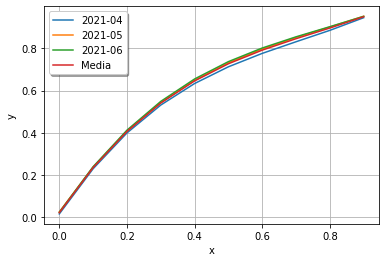

In [648]:
# Lineas
x_line = arange(0,1,0.1)
cn = 'Chile'
dic = {}
for i in final_m1[final_m1['Country'] == cn]['Month'].unique():
    a = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['A']
    b = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['B']
    c = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['C']
    d = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['D']
    dic[i] = objective(x_line,a,b,c,d)
    if i == final_m1[final_m1['Country'] == cn]['Month'].max():
        am = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['A_Media']
        bm = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['B_Media']
        cm = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['C_Media']
        dm = final_m1[(final_m1['Country'] == cn)&(final_m1['Month'] == i)]['D_Media']
        dic['Media'] = objective(x_line,am,bm,cm,dm)
for i in dic.keys():
    plt.plot(x_line,dic[i],label=i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [649]:
# Testeo el error de los vouchers en el modelo
params_m1 = {}
for i in final_m1['Country'].unique():
    l = []
    l.append(final_m1[final_m1['Country'] == i]['A_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['B_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['C_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['D_Media'].mean())
    params_m1[i] = l
datos_m1 = {}
for i in m1['Country'].unique():
    l = []
    for j in m1[m1['Country'] == i]['Month'].unique():
        dic = {}
        dic['Month'] = j
        dic['X'] = [0] + m1[(m1['Country'] == i)&(m1['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + m1[(m1['Country'] == i)&(m1['Month'] == j)]['%M1'].tolist()
        l.append(dic)
    datos_m1[i] = l
for i in datos_m1.keys():
    for j in datos_m1[i]:
        j['Res'] = j['Y'] - objective(np.array(j['X']),params_m1[i][0],params_m1[i][1],params_m1[i][2],params_m1[i][3])
        j['SS_Res'] = np.sum(j['Res']**2)
        j['SS_Tot'] = np.sum((j['Y'] - np.mean(j['Y']))**2)
        j['R_Sq'] = 1 - j['SS_Res'] / j['SS_Tot']

In [650]:
# Veo los resultados
for i in datos_m1.keys():
    for j in datos_m1[i]:
        print(i+'-'+j['Month']+'->R_Sq: '+str(round(j['R_Sq'],4)))

Argentina-2021-04->R_Sq: 0.9977
Argentina-2021-05->R_Sq: 0.9984
Argentina-2021-06->R_Sq: 0.9978
Bolivia-2021-04->R_Sq: 0.9973
Bolivia-2021-05->R_Sq: 0.999
Bolivia-2021-06->R_Sq: 0.9968
Chile-2021-04->R_Sq: 0.9968
Chile-2021-05->R_Sq: 0.9988
Chile-2021-06->R_Sq: 0.9987
Costa Rica-2021-04->R_Sq: 0.9986
Costa Rica-2021-05->R_Sq: 0.9994
Costa Rica-2021-06->R_Sq: 0.9958
Ecuador-2021-04->R_Sq: 0.9668
Ecuador-2021-05->R_Sq: 0.9865
Ecuador-2021-06->R_Sq: 0.996
El Salvador-2021-04->R_Sq: 0.9926
El Salvador-2021-05->R_Sq: 0.9919
El Salvador-2021-06->R_Sq: 0.9974
Guatemala-2021-04->R_Sq: 0.9982
Guatemala-2021-05->R_Sq: 0.9871
Guatemala-2021-06->R_Sq: 0.9924
Honduras-2021-04->R_Sq: 0.9933
Honduras-2021-05->R_Sq: 0.9972
Honduras-2021-06->R_Sq: 0.9864
Panamá-2021-04->R_Sq: 0.9889
Panamá-2021-05->R_Sq: 0.9945
Panamá-2021-06->R_Sq: 0.9952
Paraguay-2021-04->R_Sq: 0.9718
Paraguay-2021-05->R_Sq: 0.975
Paraguay-2021-06->R_Sq: 0.9961
Perú-2021-04->R_Sq: 0.9912
Perú-2021-05->R_Sq: 0.9982
Perú-2021-06->R_Sq:

##### M1 VOUCHER

In [651]:
# Creo columna acumulada de M1 Vouchers
m1v['Cum_Reorders'] = m1v.groupby(by=['Country','Month'])['Reorders'].cumsum()
m1v['Cum_M1'] = m1v['Cum_Reorders'] / m1v['Acq']
m1v.replace([np.nan,np.inf,-np.inf],'-',inplace=True)
# Creo las columnas necesarias
we = ['Friday','Saturday','Sunday']
m1v['Weekday'] = m1v['M1_Fecha'].dt.day_name()
m1v['Weekday Value'] = m1v['Weekday'].apply(lambda x: 1.4 if x in we else 1)
m1v['Cum_Weekday'] = m1v.groupby(by=['Country','Month'])['Weekday Value'].cumsum()
m1v = m1v.merge(m1v.groupby(['Country','Month'],sort=False)['Weekday Value'].sum().reset_index(name='Month Value'),on=['Country','Month'],how='left')
m1v = m1v.merge(m1v.groupby(['Country','Month'],sort=False)['Cum_M1'].max().reset_index(name='Month M1'),on=['Country','Month'],how='left')
m1v['%Month'] = m1v['Cum_Weekday'] / m1v['Month Value']
m1v['%M1'] = m1v['Cum_M1'] / m1v['Month M1']
m1v.replace([np.nan,np.inf,-np.inf],'-',inplace=True)

In [652]:
# Carmbio el formato a la fecha de M1 Vouchers
m1v[['Month','M1_Fecha']] = m1v[['Month','M1_Fecha']].astype(str)
# Borro a Colombia y Brasil de la lista
m1v = m1v[~m1v['Country'].isin(['Brasil','Colombia'])].copy()

In [653]:
# Armo diccionario para el modelo
lista_m1v = []
for i in m1v['Country'].unique():
    for j in m1v[m1v['Country'] == i]['Month'].unique():
        dic = {}
        dic['Country'] = i
        dic['Month'] = j
        dic['X'] = [0] + m1v[(m1v['Country'] == i)&(m1v['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + m1v[(m1v['Country'] == i)&(m1v['Month'] == j)]['%M1'].tolist()
        lista_m1v.append(dic)

In [654]:
# Creo las curvas de M1 Vouchers
for i in lista_m1v:
    popt,_ = curve_fit(objective,i['X'],i['Y'])
    a,b,c,d = popt
    i['A'] = a
    i['B'] = b
    i['C'] = c
    i['D'] = d

In [655]:
# Creo el DF de M1 Vouchers
final_m1v = copy.deepcopy(lista_m1v)
for i in final_m1v:
    i.pop('X',None)
    i.pop('Y',None)
final_m1v = pd.DataFrame(final_m1v)
# Creo las columnas de Means
final_m1v = final_m1v.merge(final_m1v.groupby(['Country'],sort=False)['A'].mean().reset_index(name='A_Media'),on=['Country'],how='left')
final_m1v = final_m1v.merge(final_m1v.groupby(['Country'],sort=False)['B'].mean().reset_index(name='B_Media'),on=['Country'],how='left')
final_m1v = final_m1v.merge(final_m1v.groupby(['Country'],sort=False)['C'].mean().reset_index(name='C_Media'),on=['Country'],how='left')
final_m1v = final_m1v.merge(final_m1v.groupby(['Country'],sort=False)['D'].mean().reset_index(name='D_Media'),on=['Country'],how='left')

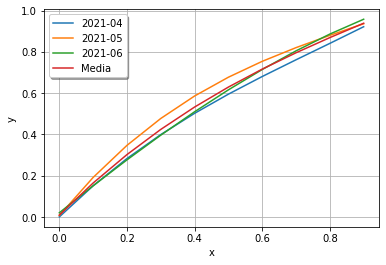

In [693]:
# Lineas
x_line = arange(0,1,0.1)
cn = 'Bolivia'
dic = {}
for i in final_m1v[final_m1v['Country'] == cn]['Month'].unique():
    a = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['A']
    b = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['B']
    c = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['C']
    d = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['D']
    dic[i] = objective(x_line,a,b,c,d)
    if i == final_m1v[final_m1v['Country'] == cn]['Month'].max():
        am = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['A_Media']
        bm = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['B_Media']
        cm = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['C_Media']
        dm = final_m1v[(final_m1v['Country'] == cn)&(final_m1v['Month'] == i)]['D_Media']
        dic['Media'] = objective(x_line,am,bm,cm,dm)
for i in dic.keys():
    plt.plot(x_line,dic[i],label=i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [657]:
# Testeo el error de los vouchers en el modelo total
params_m1 = {}
for i in final_m1['Country'].unique():
    l = []
    l.append(final_m1[final_m1['Country'] == i]['A_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['B_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['C_Media'].mean())
    l.append(final_m1[final_m1['Country'] == i]['D_Media'].mean())
    params_m1[i] = l
datos_m1v = {}
for i in m1v['Country'].unique():
    l = []
    for j in m1v[m1v['Country'] == i]['Month'].unique():
        dic = {}
        dic['Month'] = j
        dic['X'] = [0] + m1v[(m1v['Country'] == i)&(m1v['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + m1v[(m1v['Country'] == i)&(m1v['Month'] == j)]['%M1'].tolist()
        l.append(dic)
    datos_m1v[i] = l
for i in datos_m1v.keys():
    for j in datos_m1v[i]:
        j['Res'] = j['Y'] - objective(np.array(j['X']),params_m1[i][0],params_m1[i][1],params_m1[i][2],params_m1[i][3])
        j['SS_Res'] = np.sum(j['Res']**2)
        j['SS_Tot'] = np.sum((j['Y'] - np.mean(j['Y']))**2)
        j['R_Sq'] = 1 - j['SS_Res'] / j['SS_Tot']

In [658]:
# Veo los resultados
for i in datos_m1v.keys():
    for j in datos_m1v[i]:
        print(i+'-'+j['Month']+'->R_Sq: '+str(round(j['R_Sq'],4)))

Argentina-2021-04->R_Sq: 0.9791
Argentina-2021-05->R_Sq: 0.9827
Argentina-2021-06->R_Sq: 0.995
Bolivia-2021-04->R_Sq: 0.885
Bolivia-2021-05->R_Sq: 0.9819
Bolivia-2021-06->R_Sq: 0.9154
Chile-2021-04->R_Sq: 0.9245
Chile-2021-05->R_Sq: 0.9957
Chile-2021-06->R_Sq: 0.9894
Costa Rica-2021-04->R_Sq: 0.9858
Costa Rica-2021-05->R_Sq: 0.9958
Costa Rica-2021-06->R_Sq: 0.9596
Ecuador-2021-04->R_Sq: 0.9973
Ecuador-2021-05->R_Sq: 0.9723
Ecuador-2021-06->R_Sq: 0.9714
El Salvador-2021-04->R_Sq: 0.9213
El Salvador-2021-05->R_Sq: 0.9407
El Salvador-2021-06->R_Sq: 0.994
Guatemala-2021-04->R_Sq: 0.9889
Guatemala-2021-05->R_Sq: 0.9349
Guatemala-2021-06->R_Sq: 0.9953
Honduras-2021-04->R_Sq: 0.959
Honduras-2021-05->R_Sq: 0.9677
Honduras-2021-06->R_Sq: 0.9856
Panamá-2021-04->R_Sq: 0.8554
Panamá-2021-05->R_Sq: 0.9823
Panamá-2021-06->R_Sq: 0.996
Paraguay-2021-04->R_Sq: 0.9764
Paraguay-2021-05->R_Sq: 0.631
Paraguay-2021-06->R_Sq: 0.7393
Perú-2021-04->R_Sq: 0.9897
Perú-2021-05->R_Sq: 0.9716
Perú-2021-06->R_Sq: 0.

#### REORDER

In [659]:
# Creo PT General por mes
pt_reo = reo.pivot_table(index=['Month','Country'],values=['Users','Reorders'],aggfunc={'Users':np.median,'Reorders':np.sum},fill_value=0).reset_index()
pt_reo['%Reorder'] = pt_reo['Reorders'] / pt_reo['Users']
pt_reo.replace([np.nan,np.inf,-np.inf],'-',inplace=True)
pt_reo.sort_values(by=['Country','Month'],inplace=True)

In [660]:
# Creo columna acumulada de M1
reo['Cum_Reorders'] = reo.groupby(by=['Country','Month'])['Reorders'].cumsum()
reo['Cum_Reorder'] = reo['Cum_Reorders'] / reo['Users']
reo.replace([np.nan,np.inf,-np.inf],'-',inplace=True)
# Creo las columnas necesarias
we = ['Friday','Saturday','Sunday']
reo['Weekday'] = reo['Reorder_Fecha'].dt.day_name()
reo['Weekday Value'] = reo['Weekday'].apply(lambda x: 1.4 if x in we else 1)
reo['Cum_Weekday'] = reo.groupby(by=['Country','Month'])['Weekday Value'].cumsum()
reo = reo.merge(reo.groupby(['Country','Month'],sort=False)['Weekday Value'].sum().reset_index(name='Month Value'),on=['Country','Month'],how='left')
reo = reo.merge(reo.groupby(['Country','Month'],sort=False)['Cum_Reorder'].max().reset_index(name='Month Reorder'),on=['Country','Month'],how='left')
reo['%Month'] = reo['Cum_Weekday'] / reo['Month Value']
reo['%Reorder'] = reo['Cum_Reorder'] / reo['Month Reorder']
reo.replace([np.nan,np.inf,-np.inf],'-',inplace=True)

In [661]:
# Carmbio el formato a la fecha de Reorder
reo[['Month','Reorder_Fecha']] = reo[['Month','Reorder_Fecha']].astype(str)
# Borro a Colombia y Brasil de la lista
reo = reo[~reo['Country'].isin(['Brasil','Colombia'])].copy()

In [662]:
# Armo diccionario para el modelo
lista_reorder = []
for i in reo['Country'].unique():
    for j in reo[reo['Country'] == i]['Month'].unique():
        dic = {}
        dic['Country'] = i
        dic['Month'] = j
        dic['X'] = [0] + reo[(reo['Country'] == i)&(reo['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + reo[(reo['Country'] == i)&(reo['Month'] == j)]['%Reorder'].tolist()
        lista_reorder.append(dic)

In [663]:
# Creo las curvas de Reorder
for i in lista_reorder:
    popt,_ = curve_fit(objective,i['X'],i['Y'])
    a,b,c,d = popt
    i['A'] = a
    i['B'] = b
    i['C'] = c
    i['D'] = d

In [664]:
# Creo el DF de Reorder
final_reo = copy.deepcopy(lista_reorder)
for i in final_reo:
    i.pop('X',None)
    i.pop('Y',None)
final_reo = pd.DataFrame(final_reo)
# Creo las columnas de Means
final_reo = final_reo.merge(final_reo.groupby(['Country'],sort=False)['A'].mean().reset_index(name='A_Media'),on=['Country'],how='left')
final_reo = final_reo.merge(final_reo.groupby(['Country'],sort=False)['B'].mean().reset_index(name='B_Media'),on=['Country'],how='left')
final_reo = final_reo.merge(final_reo.groupby(['Country'],sort=False)['C'].mean().reset_index(name='C_Media'),on=['Country'],how='left')
final_reo = final_reo.merge(final_reo.groupby(['Country'],sort=False)['D'].mean().reset_index(name='D_Media'),on=['Country'],how='left')

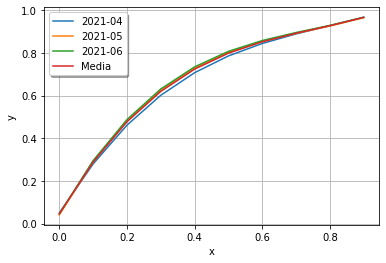

In [672]:
# Lineas
x_line = arange(0,1,0.1)
cn = 'Argentina'
dic = {}
for i in final_reo[final_reo['Country'] == cn]['Month'].unique():
    a = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['A']
    b = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['B']
    c = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['C']
    d = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['D']
    dic[i] = objective(x_line,a,b,c,d)
    if i == final_reo[final_reo['Country'] == cn]['Month'].max():
        am = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['A_Media']
        bm = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['B_Media']
        cm = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['C_Media']
        dm = final_reo[(final_reo['Country'] == cn)&(final_reo['Month'] == i)]['D_Media']
        dic['Media'] = objective(x_line,am,bm,cm,dm)
for i in dic.keys():
    plt.plot(x_line,dic[i],label=i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [668]:
# Testeo el error de los vouchers en el modelo total
params_reo = {}
for i in final_reo['Country'].unique():
    l = []
    l.append(final_reo[final_reo['Country'] == i]['A_Media'].mean())
    l.append(final_reo[final_reo['Country'] == i]['B_Media'].mean())
    l.append(final_reo[final_reo['Country'] == i]['C_Media'].mean())
    l.append(final_reo[final_reo['Country'] == i]['D_Media'].mean())
    params_reo[i] = l
datos_reo = {}
for i in reo['Country'].unique():
    l = []
    for j in reo[reo['Country'] == i]['Month'].unique():
        dic = {}
        dic['Month'] = j
        dic['X'] = [0] + reo[(reo['Country'] == i)&(reo['Month'] == j)]['%Month'].tolist()
        dic['Y'] = [0] + reo[(reo['Country'] == i)&(reo['Month'] == j)]['%Reorder'].tolist()
        l.append(dic)
    datos_reo[i] = l
for i in datos_reo.keys():
    for j in datos_reo[i]:
        j['Res'] = j['Y'] - objective(np.array(j['X']),params_reo[i][0],params_reo[i][1],params_reo[i][2],params_reo[i][3])
        j['SS_Res'] = np.sum(j['Res']**2)
        j['SS_Tot'] = np.sum((j['Y'] - np.mean(j['Y']))**2)
        j['R_Sq'] = 1 - j['SS_Res'] / j['SS_Tot']

In [669]:
# Veo los resultados
for i in datos_reo.keys():
    for j in datos_reo[i]:
        print(i+'-'+j['Month']+'->R_Sq: '+str(round(j['R_Sq'],4)))

Argentina-2021-04->R_Sq: 0.9959
Argentina-2021-05->R_Sq: 0.9969
Argentina-2021-06->R_Sq: 0.9965
Bolivia-2021-04->R_Sq: 0.993
Bolivia-2021-05->R_Sq: 0.9959
Bolivia-2021-06->R_Sq: 0.9969
Chile-2021-04->R_Sq: 0.9973
Chile-2021-05->R_Sq: 0.9981
Chile-2021-06->R_Sq: 0.9983
Costa Rica-2021-04->R_Sq: 0.9842
Costa Rica-2021-05->R_Sq: 0.9984
Costa Rica-2021-06->R_Sq: 0.9884
Ecuador-2021-04->R_Sq: 0.9843
Ecuador-2021-05->R_Sq: 0.9912
Ecuador-2021-06->R_Sq: 0.9976
El Salvador-2021-04->R_Sq: 0.9942
El Salvador-2021-05->R_Sq: 0.9933
El Salvador-2021-06->R_Sq: 0.9945
Guatemala-2021-04->R_Sq: 0.976
Guatemala-2021-05->R_Sq: 0.9935
Guatemala-2021-06->R_Sq: 0.996
Honduras-2021-04->R_Sq: 0.9324
Honduras-2021-05->R_Sq: 0.969
Honduras-2021-06->R_Sq: 0.9965
Panamá-2021-04->R_Sq: 0.9975
Panamá-2021-05->R_Sq: 0.9967
Panamá-2021-06->R_Sq: 0.9968
Paraguay-2021-04->R_Sq: 0.9965
Paraguay-2021-05->R_Sq: 0.9965
Paraguay-2021-06->R_Sq: 0.9935
Perú-2021-04->R_Sq: 0.9892
Perú-2021-05->R_Sq: 0.9967
Perú-2021-06->R_Sq: 

#### DF R_SQ

In [690]:
# Veo los resultados
l = []
for i in datos_reo.keys():
    for j in datos_reo[i]:
        dic = {}
        dic['Tipo'] = 'Reorder'
        dic['Country'] = i
        dic['Month'] = j['Month']
        dic['R_Sq'] = round(j['R_Sq'],6)
        l.append(dic)
for i in datos_m1.keys():
    for j in datos_m1[i]:
        dic = {}
        dic['Tipo'] = 'M1'
        dic['Country'] = i
        dic['Month'] = j['Month']
        dic['R_Sq'] = round(j['R_Sq'],6)
        l.append(dic)
for i in datos_m1v.keys():
    for j in datos_m1v[i]:
        dic = {}
        dic['Tipo'] = 'M1 Vouchers'
        dic['Country'] = i
        dic['Month'] = j['Month']
        dic['R_Sq'] = round(j['R_Sq'],6)
        l.append(dic)
r_sq = pd.DataFrame(l)

### CARGA

In [444]:
carga(m1,'1oPgQD_OAlJyVMUWunOSTLxzUwvc3FSbSWF5xV4xMbk8','Crudo M1')

Carga Correcta!


In [445]:
carga(final_m1,'1oPgQD_OAlJyVMUWunOSTLxzUwvc3FSbSWF5xV4xMbk8','Curvas M1')

Carga Correcta!


In [446]:
carga(reo,'1oPgQD_OAlJyVMUWunOSTLxzUwvc3FSbSWF5xV4xMbk8','Crudo Reorder')

Carga Correcta!


In [447]:
carga(final_reo,'1oPgQD_OAlJyVMUWunOSTLxzUwvc3FSbSWF5xV4xMbk8','Curvas Reorder')

Carga Correcta!


In [691]:
carga(r_sq,'1oPgQD_OAlJyVMUWunOSTLxzUwvc3FSbSWF5xV4xMbk8','R_Square')

Carga Correcta!
